In [204]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, time

plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams.update({'font.size': 12})

# modifiable parameters (to run the task)
TEST_TASK_1 = True
TEST_TASK_2 = True
TEST_TASK_3 = True

# ** Task 1 modifiable parameters, if enabled
TASK_1_DIRECTORY = 'DataSamples'
TASK_1_IMAGE = 's4.jpg' # 's1' to 's5'

# ** Task 2 modifiable parameters, if enabled
TASK_2_DIRECTORY = 'high_qual_images'
TASK_2_IMAGE = '00911u.jpg' # '00549u', '00911u'

TASK_2_ATTEMPTS = 10  # num iterations (downsampling factors) to attempt
TASK_2_RUNTIME_SECONDS_THRESHOLD = 2  # tolerable num seconds taken by cur loop before we terminate after this loop

TASK_2_REDUCE_ROI = True  # enable to make image pyramid layers relate to one another between scans
TASK_2_BORDER_WINDOW_SHRINK_RATIO = 0.125  # bet. [0,1]. used to control border narrowing on each image pyramid layer
# ^ (the above 2 params will only work well if the result converges as the resolution is improved)
# '00549u' --> 0.5
# '00911u' --> 0.125

# ** Task 3 parameters, if enabled
TASK_3_DIRECTORY = 'DataSamples'
TASK_3_IMAGE_1 = 's1.jpg'
TASK_3_IMAGE_2 = 's2.jpg'
TASK_3_IMAGE_3 = 's5.jpg'

### Instructions

To run this code, set the configurable parameters above and then 'Run All Cells'.

`TEST_TASK_X` controls whether that task should be run.

#### Task 2 - Specific

Specific to Task 2, my implementation of an image pyramid uses `TASK_2_ATTEMPTS` to control how many factors to downsample by, as I believe this can be a subjective metric. For instance, there is no reason to downsample all the way down the tip of the pyramid (i.e. where the downscaled image is now a 1x1 pixel, as this provides no real computational benefit for us).

In addition, `TASK_2_RUNTIME_SECONDS_THRESHOLD` prevents any further iterations from being run if the latest iteration of the image pyramid loop has already exceeded this threshold. This has been done as, although my image pyramid algorithm is MEANT to incrementally improve on the windowed RoI to reduce the amount of template matching scanning needing to be done (if `TASK_2_REDUCE_ROI` is enabled, and `TASK_2_BORDER_WINDOW_SHRINK_RATIO` is set to some ratio between 0 and 1), it could be the case that the window size is still be too generous. This is particularly true if some runaway effect is observed at intermediate image pyramid levels, which makes it hard to argue that the image pyramid result will lead to convergence, as one iterates up the upscaled levels.

### Task 1

If nothing is showing, please enable `TEST_TASK_1` at the top of this file. You can change which image to apply the implementation by configuring `TASK_1_DIRECTORY` to point to the desired directory containing the desired image, named `TASK_1_IMAGE`.

In [205]:
# From Lab 1, Question 2.2
# https://theailearner.com/2019/04/10/histogram-matching-specification/

# Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
# Note: function only logically works for greyscale / 1-channel at a time
# (asked tutor - this method is too good for Lab 1)
def histMatch(source, template):
    pixel_type = type(source[0][0])
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    # * (can be later reshaped to 2D image if pixel order does not change)

    # get the set of unique pixel values and their corresponding 
    # indices and counts (better than doing a histogram as this tells
    # you where the pixels are located)
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    # * (return_inverse) --> returns indices for that unique value
    #      --> you can reconstruct ar from all the collected indices
    # * (only need to match indexes of src image to template's histogram)
    
    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    # * (cumsum just does a sums of: cur_val + prev_vals, per iteration)
    # * (i.e. from lecture slides, nk(s_counts) / MN(total_pixels))
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(pixel_type)
    # * (vals in a 3 channel greyscale img are triple-counted; seems safe)

    return interp_t_values[bin_idx].reshape(oldshape) # cast back to 2D img

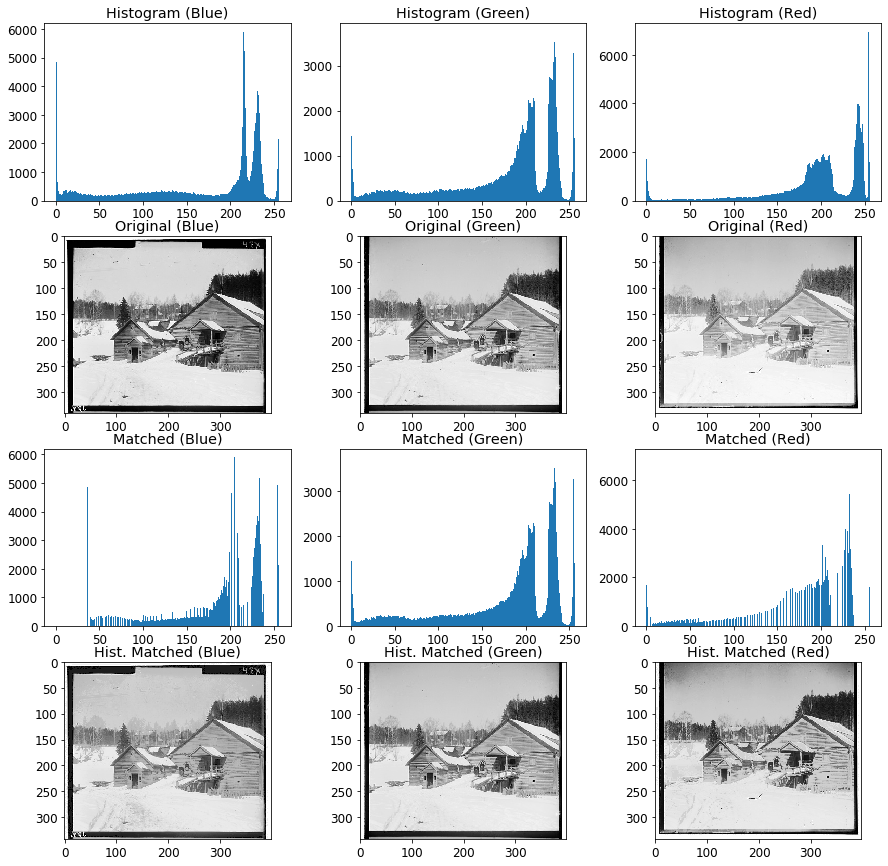

In [206]:
# reads image, partitions it into three sub-images. assumed image structure (b,g,r) descending
def getImageComponents(fp):
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    nrows = img.shape[0]
    height = int(np.ceil(nrows/3))
    g_start = int(np.round((nrows - height)/2))
    # split img into thirds
    b = img[:height, :]
    g = img[g_start:g_start+height, :]
    r = img[-height:, :]
    return b,g,r

height = lambda img : img.shape[0]
width = lambda img : img.shape[1]

# https://robotacademy.net.au/lesson/template-matching/
#####################################################
# METRICS
def _ssdMetric(A,B): # sum of squared differences
    return ((A-B)**2).sum()

def _ssdBestValue(metric_result):
    best_index = np.unravel_index(np.argmin(metric_result, axis=None), metric_result.shape)
    return best_index # corresponds to img offset
    
def _sadMetric(A,B): # sum of absolute differences
    return (abs(A-B)).sum()

def _sadBestValue(metric_result):
    return _ssdBestValue(metric_result) # get min
    
# https://stackoverflow.com/questions/15215310/special-situation-in-normalized-cross-correlation-for-template-matching
def _nccMetric(A,B): # normalised cross-correlation
    return (A*B).sum() / np.sqrt((A**2).sum() * (B**2).sum())  # maybe wrong? div by 0 sometimes

# https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)
def _nccMetric(A,B, meanA,stdA, meanB,stdB):
    components = (A - meanA) * (B - meanB) / (stdA * stdB)
    return components.sum() / (A.size + B.size)  # likely v. slow

def _nccBestValue(metric_result): # correlation == 1, gives perfect match
    best_index = np.unravel_index(np.argmax(metric_result, axis=None), metric_result.shape)
    return best_index
    
#####################################################
# comparison logic: doesn't work as expected. Why?
# TM_SQDIFF, TM_SQDIFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_CCOEFF, TM_CCOEFF_NORMED
#def _matchTemplateCv2(mt_img, mt_template, cv_method=cv2.TM_SQDIFF_NORMED):
#    mt_result = cv2.matchTemplate(mt_img, mt_template, cv_method)
#    _, _, mt_locmin, mt_locmax = cv2.minMaxLoc(mt_result)
#    if cv_method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
#        mt_start = mt_locmin
#    else:
#        mt_start = mt_locmax
#    #mt_stop  = (mt_start[0]+width(mt_img), mt_start[1]+height(mt_img))
#    return mt_start #, mt_stop # (top left, bot right) each in (r,c) format


# img is searched through all possible offsets of a padded temp(late)
def _matchTemplate(img, temp, borders, prev_offset=None, border_scale=None):
    if prev_offset == None:
        prev_offset = (0,0)
    if border_scale == None:
        wborders = borders
    else:
        print(" * border scale:", border_scale)
        wborders = [int(borders[i] * border_scale) for i in range(2)]
    # find range in which img can sweep across (padded) template
    # (Task 2 idea: create window with border around the previous offset (clipped by g's border))
    img_nr, img_nc = img.shape
    temp_nr, temp_nc = temp.shape
    wstart = [ max(prev_offset[i]-int(wborders[i]), 0) for i in range(2) ]   # clipped windowing <= 2*border_size
    wstop = [ min(wstart[i] + img.shape[i] + 2*wborders[i] -1, temp.shape[i]-1) for i in range(2) ] # can get clipped
    woff_r, woff_c = wstart
    
    maxshift_r = max(wstop[0] - wstart[0] - img_nr,0)
    maxshift_c = max(wstop[1] - wstart[1] - img_nc,0)
    roi_percent = 100*(maxshift_r+img_nr)*(maxshift_c+img_nc) / (temp_nr*temp_nc) 
    print(" * maxshift ratio: r={:.2f}, c={:.2f}".format(maxshift_r/temp_nr, maxshift_c/temp_nc))
    print(" * Template match (RoI area): {:.2f}% of total area".format(roi_percent))
    
    #img_mean, img_std = cv2.meanStdDev(img)     # used for zncc, if used  [MODIFIABLE PARAM]
    #temp_mean, temp_std = cv2.meanStdDev(temp)
    
    metric_result = np.zeros((maxshift_r +1, maxshift_c +1))
    for r in range(maxshift_r +1):
        for c in range(maxshift_c +1):
            # construct window from template (same size as img)
            temp_window = temp[r+woff_r : r+woff_r + img_nr, 
                               c+woff_c : c+woff_c + img_nc]
            
            # compute similarity metric                          # <--[MODIFIABLE PARAM]
            metric_result[r,c] = _ssdMetric(img, temp_window)
            #metric_result[r,c] = _nccMetric(img, temp_window, img_mean,img_std, temp_mean,temp_std)
            
            #print("mt: off({},{}): imgsize={} (tempsize={}); res={}".format(r,c,img.shape,temp.shape,metric_result[r,c]))
    
    # choose optimal similarity result                           # <--[MODIFIABLE PARAM]
    offset_r, offset_c = _ssdBestValue(metric_result)
    
    return offset_r+woff_r, offset_c+woff_c # remove window offset
    
    
# generates a padded version of the image (with the same shape as the temp(late)),
# with the computed offset applied to it
def _getOffsetImage(img, temp, offset_r, offset_c):
    img_nr, img_nc = img.shape
    # generate offsetted image
    #print('i,t,o:', img_nr, img_nc, temp.shape, offset_r, offset_c)
    new_img = np.zeros(temp.shape, dtype=type(temp[0,0]))
    new_img[offset_r : (offset_r + img_nr), offset_c : (offset_c + img_nc)] = img
    return new_img


# convenience function to set up calls to:   _matchTemplate()
# returns:
#  * b_offsets(r,c): offset that needs to be applied to img 'b' to align with 'g_new'
#  * g_new: 'g' with a zero-padded border on all sides
#  * r_offsets(r,c): same as b_offsets, but for 'r'
#  * borders(r,c): border (width,length) applied to EACH edge of 'g'
#
# note: border_scale is an arg for image pyramids only (poorly named)
def alignComponents(b,g,r, b_prev_offset=None, r_prev_offset=None, border_scale=None):
    # assume g == template (most accurately sliced)
    divisor = 16   # original method used: divisor=2
    bord_r = int(g.shape[0]/divisor)
    bord_c = int(g.shape[1]/divisor)
    if bord_r < 10: # weird hack for tiny imgs
        bord_r = max(int(g.shape[0]/2), 1)
    if bord_c < 10:
        bord_c = max(int(g.shape[1]/2), 1)
    borders = (bord_r, bord_c)
    
    add_border = lambda l: (l[0] + int(bord_r/2), l[1] + int(bord_c/2))
    if b_prev_offset != None:
        b_prev_offset = add_border(b_prev_offset)
    if r_prev_offset != None:
        r_prev_offset = add_border(r_prev_offset)
        
    g_new = cv2.copyMakeBorder(g, bord_r, bord_r, bord_c, bord_c, cv2.BORDER_CONSTANT)#, value=255)
    print("Image shape:", g.shape)
    print("Image padding: nrow={}, ncol={}".format(bord_r, bord_c))
    
    # compare: r,b <--> g (template)
    r_time = time.time()
    print("Running template match on (r,g)")
    r_offset_row, r_offset_col = _matchTemplate(r, g_new, borders, r_prev_offset, border_scale)   # <--[MODIFIABLE PARAM]
    print(" * [Done]: took {} seconds.".format(time.time() - r_time))
    
    b_time = time.time()
    print("Running template match on (b,g)")
    b_offset_row, b_offset_col = _matchTemplate(b, g_new, borders, b_prev_offset, border_scale)   # <--[MODIFIABLE PARAM]
    print(" * [Done]: took {} seconds.".format(time.time() - b_time))
    return (b_offset_row, b_offset_col), g_new, (r_offset_row, r_offset_col), (bord_r, bord_c)
    
# (hacked off this subfunction from alignComponents() to allow for histogram matching injection)
# convenience function to set up calls to:   _getOffsetImage()
def applyAlignment(b,g_new,r, b_offsets,r_offsets):
    r_offset_row, r_offset_col = r_offsets
    b_offset_row, b_offset_col = b_offsets
    
    print("Red  offset: row={}, col={}".format(r_offset_row, r_offset_col))
    print("Blue offset: row={}, col={}".format(b_offset_row, b_offset_col))
    r_new = _getOffsetImage(r, g_new, r_offset_row, r_offset_col)
    b_new = _getOffsetImage(b, g_new, b_offset_row, b_offset_col)
    
    return b_new, r_new

# computes the RoI to remove the border from the padded result of 'g'
def getCropAlignmentOrig(borders,g): # cut back to size 'g'
    img_nr, img_nc = g.shape
    bord_r, bord_c = borders
    #crop = lambda bigimg : bigimg[ bord_r:bord_r+img_nr , bord_c:bord_c+img_nc ]
    return bord_r,bord_r+img_nr , bord_c,bord_c+img_nc

# reduce overall img size to remove colored bars --> performs poorly
def getCropAlignment(borders,g, b_offset, r_offset):  # all args in (r,c)
    img_nr, img_nc = g.shape
    def getValues(i):
        i_start = max(borders[i],b_offset[i],r_offset[i])
        i_diff = max(abs(borders[i]-b_offset[i]), abs(borders[i]-r_offset[i]), abs(b_offset[i]-r_offset[i]))
        i_length = img_nr - i_diff
        i_stop = i_start+i_length
        return i_start, i_stop
    
    row_start, row_stop = getValues(0)
    col_start, col_stop = getValues(1)
    return row_start,row_stop, col_start,col_stop


#####################################################
# get image components
if TEST_TASK_1:
    fp = os.path.join(TASK_1_DIRECTORY, TASK_1_IMAGE)           # <--[MODIFIABLE PARAM]
    b,g,r = getImageComponents(fp)

    # apply histogram matching
    nr = 4
    nc = 3
    label_comps = ['Blue', 'Green', 'Red']
    img_comps = [b,g,r]
    for i in range(3):
        plt.subplot(nr,nc,i+1)
        plt.title('Histogram ({})'.format(label_comps[i]))
        plt.hist(img_comps[i].ravel(), 256, [0,256])
        plt.subplot(nr,nc,i+4)
        plt.title('Original ({})'.format(label_comps[i]))
        plt.imshow(img_comps[i], cmap=plt.get_cmap('gray'))
        
        b_mh = histMatch(b, g)
        r_mh = histMatch(r, g)

    img_comps_mh = [b_mh,g,r_mh]
    for i in range(3):
        plt.subplot(nr,nc,i+7)
        plt.title('Matched ({})'.format(label_comps[i]))
        plt.hist(img_comps_mh[i].ravel(), 256, [0,256])
        plt.subplot(nr,nc,i+10)
        plt.title('Hist. Matched ({})'.format(label_comps[i]))
        plt.imshow(img_comps_mh[i], cmap=plt.get_cmap('gray'))

    #b = b_mh # test only
    #r = r_mh    
    
    #b_mh = b # uncomment these lines to bypass hist matching
    #r_mh = r

Image shape: (342, 398)
Image padding: nrow=21, ncol=24
Running template match on (r,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.4319343566894531 seconds.
Running template match on (b,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.4555106163024902 seconds.
Red  offset: row=29, col=26
Blue offset: row=20, col=22


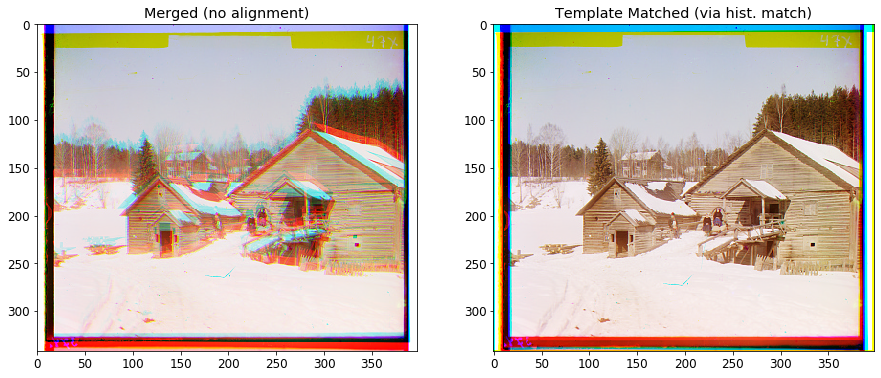

In [207]:
# RESULTS: generate & plot aligned image
if TEST_TASK_1:
    original_img_t1 = cv2.merge((b,g,r))

    b_offset, g_new, r_offset, borders = alignComponents(b_mh, g, r_mh)
    b_new, r_new = applyAlignment(b,g_new,r, b_offset,r_offset)

    #aligned_img = cv2.merge((b_new,g_new,r_new))       # <--[MODIFIABLE PARAM]; view padding
    row_start,row_stop, col_start,col_stop = getCropAlignmentOrig(borders, g)
    #row_start,row_stop, col_start,col_stop = getCropAlignment(borders, g, b_offset, r_offset)
    aligned_img_t1 = cv2.merge((b_new,g_new,r_new))[row_start:row_stop, col_start:col_stop, :]

    nr = 1
    nc = 2
    plt.subplot(nr,nc,1)
    plt.title("Merged (no alignment)")
    plt.imshow(cv2.cvtColor(original_img_t1, cv2.COLOR_BGR2RGB))
    plt.subplot(nr,nc,2)
    plt.title("Template Matched (via hist. match)")
    plt.imshow(cv2.cvtColor(aligned_img_t1, cv2.COLOR_BGR2RGB))

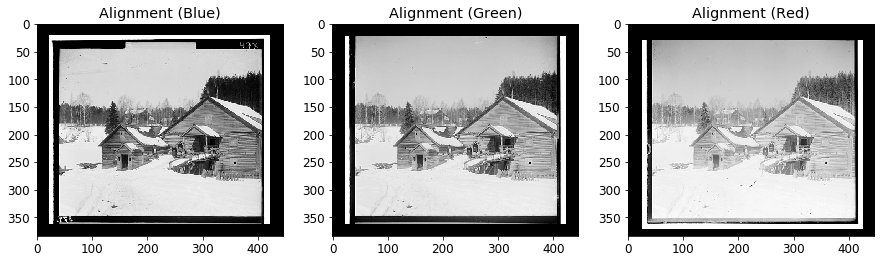

In [208]:
# RESULTS: plot subcomponents of aligned image
if TEST_TASK_1:
    nr = 1
    nc = 3
    plt.subplot(nr,nc,1)
    plt.title("Alignment (Blue)")
    plt.imshow(b_new, cmap=plt.get_cmap('gray'))
    plt.subplot(nr,nc,2)
    plt.title("Alignment (Green)")
    plt.imshow(g_new, cmap=plt.get_cmap('gray'))
    plt.subplot(nr,nc,3)
    plt.title("Alignment (Red)")
    plt.imshow(r_new, cmap=plt.get_cmap('gray'))

### Task 2

If nothing is showing, please enable `TEST_TASK_2` at the top of this file. You can change which image to apply the implementation by configuring `TASK_2_DIRECTORY` to point to the desired directory containing the desired image, named `TASK_2_IMAGE`.


[LOOP 0]: Running for downfactor: 512
Image shape: (3, 3)
Image padding: nrow=1, ncol=1
Running template match on (r,g)
 * border scale: 1.0
 * maxshift ratio: r=0.20, c=0.20
 * Template match (RoI area): 64.00% of total area
 * [Done]: took 0.008104085922241211 seconds.
Running template match on (b,g)
 * border scale: 1.0
 * maxshift ratio: r=0.20, c=0.20
 * Template match (RoI area): 64.00% of total area
 * [Done]: took 0.0 seconds.
Red  offset: row=518, col=600
Blue offset: row=518, col=600
 * Total runtime: 0.05013680458068848 seconds

[LOOP 1]: Running for downfactor: 256
Image shape: (7, 6)
Image padding: nrow=3, ncol=3
Running template match on (r,g)
 * border scale: 0.9875
 * maxshift ratio: r=0.23, c=0.25
 * Template match (RoI area): 57.69% of total area
 * [Done]: took 0.0 seconds.
Running template match on (b,g)
 * border scale: 0.9875
 * maxshift ratio: r=0.23, c=0.25
 * Template match (RoI area): 57.69% of total area
 * [Done]: took 0.0011343955993652344 seconds.
Red  of

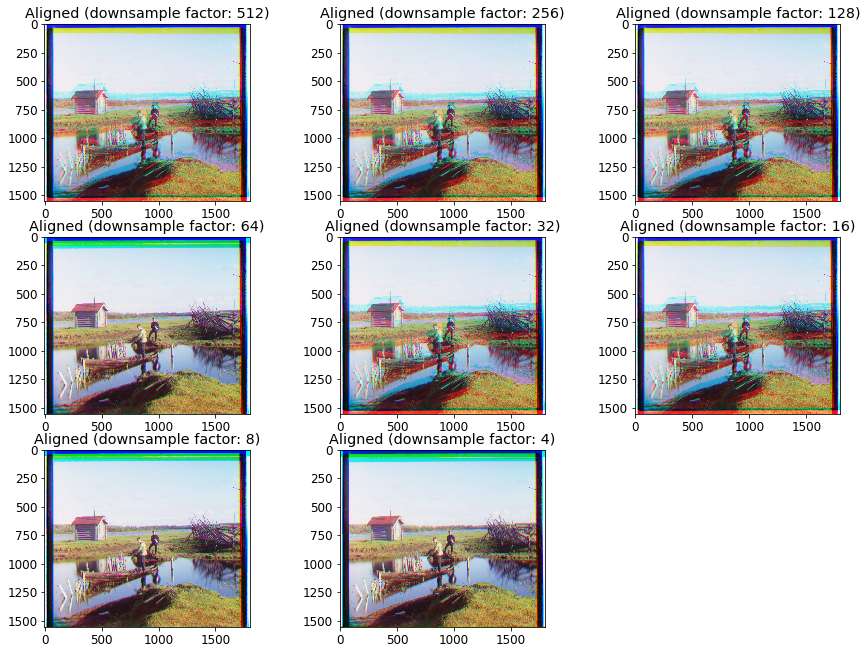

In [209]:
# wrapper for: alignComponents(b_mh, g, r_mh)
# performs 1 iteration of the image pyramid's method of image alignment
def pyramidAlignComponents(b,g,r,downscale_factor, b_prev_offset, r_prev_offset, prev_borders, border_scale):
    remove_border   = lambda l: ( max(l[0] - prev_borders[0],0) , max(l[1] - prev_borders[1],0) )
    downscale_tuple = lambda l: tuple(map(lambda elem: int(elem/downscale_factor), l))
    # downscale images (assumes all 3 are identical sizes)
    img_nr,img_nc = g.shape
    new_nr = int(img_nr/downscale_factor)
    new_nc = int(img_nc/downscale_factor)
    if b_prev_offset != None:
        b_prev_offset = downscale_tuple(remove_border(b_prev_offset))
    if r_prev_offset != None:
        r_prev_offset = downscale_tuple(remove_border(r_prev_offset))
    if new_nr < 1 or new_nc < 1:
        raise AssertionError("Factor is too small to down-sample image to this resolution")
    
    new_b = cv2.resize(b, (new_nr, new_nc))
    new_g = cv2.resize(g, (new_nr, new_nc))
    new_r = cv2.resize(r, (new_nr, new_nc))
    
    # apply image alignment
    b_offsets, _, r_offsets, border = alignComponents(new_b, new_g, new_r, b_prev_offset, r_prev_offset, border_scale)
    # (note: hacky implementation - alignComponents must add the new border size back in)
    
    # upscale received offset values (may have rounding error)
    upscale_r = img_nr/new_nr
    upscale_c = img_nc/new_nc 
    def upscale_offsets(dr,dc): 
        return (int(dr * upscale_r), int(dc * upscale_c))
    
    b_offsets = upscale_offsets(b_offsets[0],b_offsets[1])
    r_offsets = upscale_offsets(r_offsets[0],r_offsets[1])
    
    # ** reapply border to regenerate 'new_g'
    border = upscale_offsets(border[0],border[1])
    bord_r, bord_c = border
    g_bordered = cv2.copyMakeBorder(g, bord_r, bord_r, bord_c, bord_c, cv2.BORDER_CONSTANT)
    
    return b_offsets, g_bordered, r_offsets, border
    
    
#####################################################
# RESULTS: generate and plot for high resolution image

# get image components 
fp = os.path.join(TASK_2_DIRECTORY, TASK_2_IMAGE)    # <--[MODIFIABLE PARAM]
b,g,r = getImageComponents(fp)
original_img_t2 = cv2.merge((b,g,r))

# get histogram matched components
b_mh = histMatch(b, g)
r_mh = histMatch(r, g)

# perform image alignment
def getPyramidAlignedImage(b,g,r, b_mh,r_mh, downfactor, b_prev_offset, r_prev_offset, prev_borders, border_scale):
    b_offset, g_new, r_offset, borders = pyramidAlignComponents(b_mh, g, r_mh, downfactor, 
                                                                b_prev_offset, r_prev_offset, prev_borders, border_scale)
    b_new, r_new = applyAlignment(b,g_new,r, b_offset,r_offset)

    #aligned_img = cv2.merge((b_new,g_new,r_new))       # <--[MODIFIABLE PARAM]
    row_start,row_stop, col_start,col_stop = getCropAlignmentOrig(borders, g)
    aligned_img = cv2.merge((b_new,g_new,r_new))[row_start:row_stop, col_start:col_stop, :]
    return aligned_img, b_offset, r_offset, borders

# ** image alignment loop (for comparison purposes)
if TEST_TASK_2:
    nc = 3
    nr = int(np.ceil(TASK_2_ATTEMPTS/nc))
    b_prev_offset = (0,0) # initial offset; later, storage param
    r_prev_offset = (0,0)
    borders = (0,0)       # storage param

    for i in range(TASK_2_ATTEMPTS):
        downfactor = 2**(TASK_2_ATTEMPTS-1-i)
        border_scale = (TASK_2_ATTEMPTS-i*TASK_2_BORDER_WINDOW_SHRINK_RATIO)/(TASK_2_ATTEMPTS)
        print("\n[LOOP {}]: Running for downfactor: {}".format(i, downfactor))
        plt.subplot(nr,nc,i+1)
        try:
            start = time.time()
            if TASK_2_REDUCE_ROI:
                aligned_img_t2, b_prev_offset, r_prev_offset, borders = getPyramidAlignedImage(b,g,r, b_mh,r_mh, downfactor, 
                                                                                               b_prev_offset, r_prev_offset, 
                                                                                               borders, border_scale)
            else:
                aligned_img_t2, _,_,_ = getPyramidAlignedImage(b,g,r, b_mh,r_mh, downfactor, None, None, borders, 1)
            #print(" * New poffsets:", b_prev_offset, r_prev_offset)
            end = time.time()
            print(" * Total runtime: {} seconds".format(end-start))
            plt.title("Aligned (downsample factor: {})".format(downfactor))
            plt.imshow(cv2.cvtColor(aligned_img_t2, cv2.COLOR_BGR2RGB))

            if (end-start) >= TASK_2_RUNTIME_SECONDS_THRESHOLD:
                print("Stopping as subsequent runs will take too long.")
                break
        except AssertionError as e:
            print("Invalid downsampling factor; trying next value")
            continue  
            #print("Stopping:", e)
            #break


### Task 3

If nothing is showing, please enable `TEST_TASK_3` at the top of this file. 

You can change which image to apply the implementation by configuring `TASK_3_DIRECTORY` to point to the desired directory containing the desired image, named `TASK_3_IMAGE_X`; however, you probably shouldn't as the changes made may be quite subjective and specific to the image chosen.

 * Based off the histogram plot, contrast stretching is seen to have limited value.

 * Increasing contrast (generally) using a power law transform may also have limited effectiveness. 
 
 * We compare power law transform (RGB space) to CLAHE (Contrast Limited Adaptive Histogram Equalization) (LAB space).

Image shape: (342, 398)
Image padding: nrow=21, ncol=24
Running template match on (r,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.491947889328003 seconds.
Running template match on (b,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.4365835189819336 seconds.
Red  offset: row=26, col=24
Blue offset: row=15, col=23


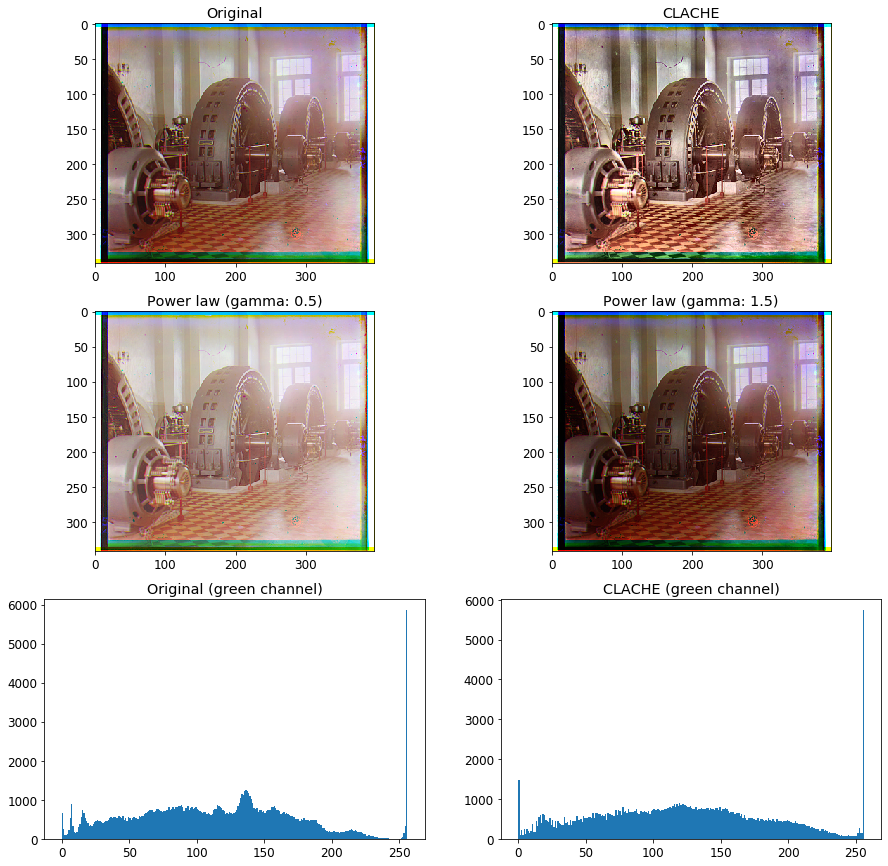

In [210]:
# Cool resource: https://anishdubey.com/image-sharpening-opencv

def getTask1(directory, image): # condensed version
    fp = os.path.join(directory, image)
    b,g,r = getImageComponents(fp)      # channels
    b_mh = histMatch(b, g)              # histogram match
    r_mh = histMatch(r, g)
    b_offset, g_new, r_offset, borders = alignComponents(b_mh, g, r_mh)  # get offset
    b_new, r_new = applyAlignment(b,g_new,r, b_offset,r_offset)          # apply offset
    # crop padding
    row_start,row_stop, col_start,col_stop = getCropAlignmentOrig(borders, g)
    aligned_img = cv2.merge((b_new,g_new,r_new))[row_start:row_stop, col_start:col_stop, :]
    #original_img = cv2.merge((b,g,r))
    return aligned_img

# Source: forgot where, but it was an online tutorial
def powerLawTransform(img, gamma):
    ptype = type(img[0][0][0])
    pmax = np.iinfo( ptype ).max
    return (pmax*(img / pmax) ** gamma).astype(ptype)

# Source: https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv/50053219#50053219
def applyCLACHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # use LAB color space
    l, a, b = cv2.split(lab)
    # apply CLAHE to L-channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    # recombine enhanced L-channel and convert back
    limg = cv2.merge((cl,a,b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

def testTask3(directory, image, hist_plot=False):
    img_t3 = getTask1(directory, image)
    gamma_light = 0.5
    gamma_dark = 1.5
    img_t3_pwrlight = powerLawTransform(img_t3, gamma_light) 
    img_t3_pwrdark = powerLawTransform(img_t3, gamma_dark)
    img_t3_clache = applyCLACHE(img_t3)
    
    nr = 2 if not hist_plot else 3
    nc = 2
    plt.subplot(nr,nc,1)
    plt.title('Original')
    plt.imshow(cv2.cvtColor(img_t3, cv2.COLOR_BGR2RGB))
    plt.subplot(nr,nc,2)
    plt.title('CLACHE')
    plt.imshow(cv2.cvtColor(img_t3_clache, cv2.COLOR_BGR2RGB))
    
    plt.subplot(nr,nc,3)
    plt.title('Power law (gamma: {})'.format(gamma_light))
    plt.imshow(cv2.cvtColor(img_t3_pwrlight, cv2.COLOR_BGR2RGB))
    plt.subplot(nr,nc,4)
    plt.title('Power law (gamma: {})'.format(gamma_dark))
    plt.imshow(cv2.cvtColor(img_t3_pwrdark, cv2.COLOR_BGR2RGB))

    if hist_plot:
        plt.subplot(nr,nc,5)
        plt.title('Original (green channel)')
        plt.hist(img_t3[:,:,1].ravel(), 256, [0,256])
        plt.subplot(nr,nc,6)
        plt.title('CLACHE (green channel)')
        plt.hist(img_t3_clache[:,:,1].ravel(), 256, [0,256])
    
    # plot colour histogram
    # label_comps = ['blue', 'green', 'red']
    # for i in range(3):
    #     plt.subplot(3,len(label_comps),i+1)
    #     plt.title('Histogram ({})'.format(label_comps[i]))
    #     plt.hist(img_t3[:,:,i].ravel(), 256, [0,256])

    
#####################################################
if TEST_TASK_3:
    testTask3(TASK_3_DIRECTORY, TASK_3_IMAGE_1, True)

Image shape: (342, 398)
Image padding: nrow=21, ncol=24
Running template match on (r,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.4262354373931885 seconds.
Running template match on (b,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.52% of total area
 * [Done]: took 1.4664545059204102 seconds.
Red  offset: row=27, col=27
Blue offset: row=16, col=19


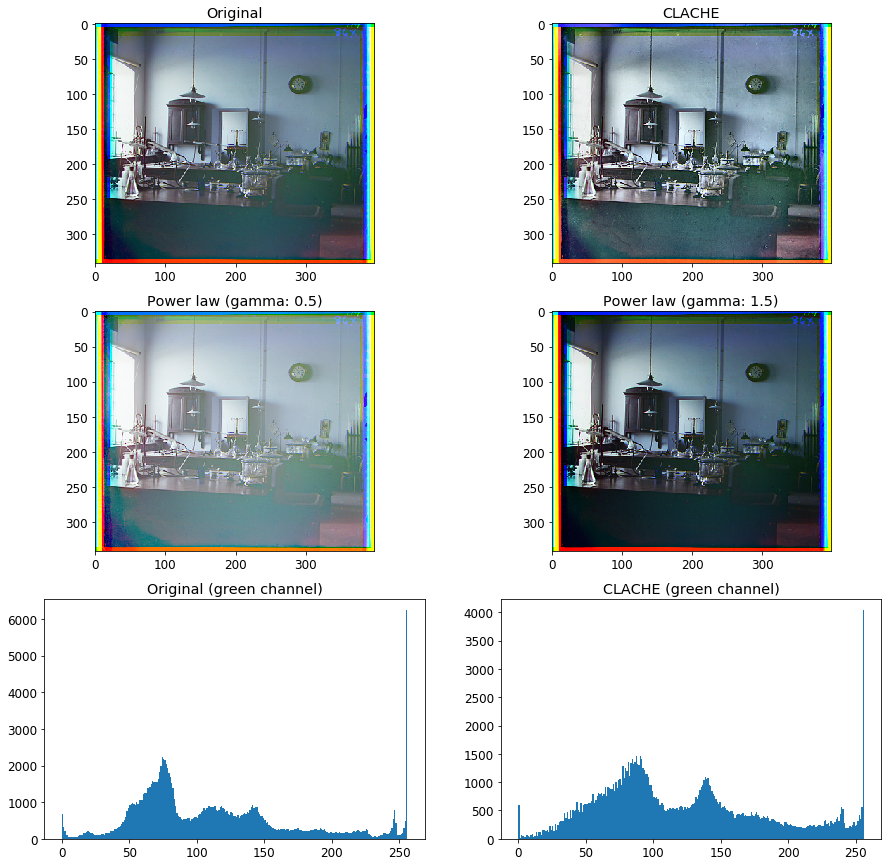

In [211]:
if TEST_TASK_3:
    testTask3(TASK_3_DIRECTORY, TASK_3_IMAGE_2, True)

Image shape: (342, 393)
Image padding: nrow=21, ncol=24
Running template match on (r,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.51% of total area
 * [Done]: took 1.4193861484527588 seconds.
Running template match on (b,g)
 * maxshift ratio: r=0.11, c=0.11
 * Template match (RoI area): 99.51% of total area
 * [Done]: took 1.4455173015594482 seconds.
Red  offset: row=22, col=25
Blue offset: row=23, col=22


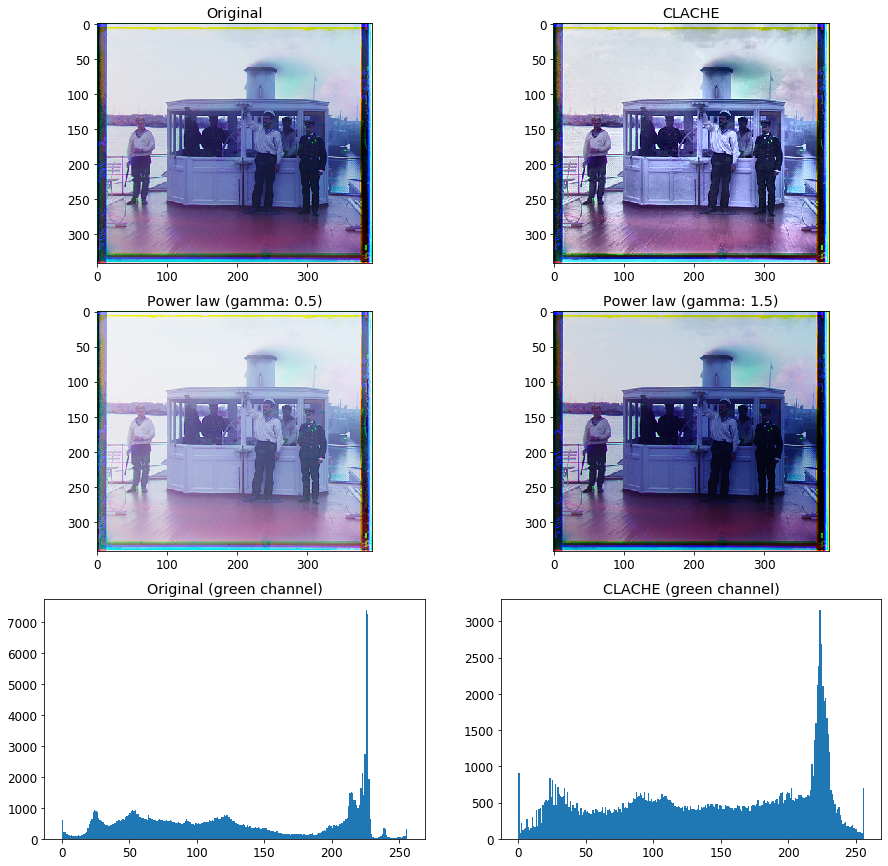

In [212]:
if TEST_TASK_3:
    testTask3(TASK_3_DIRECTORY, TASK_3_IMAGE_3, True)

In [213]:
# Mucking around with HDR functionality - correct implem, but no HDR benefit?
# if TEST_TASK_1:
#     merge_mertens = cv2.createMergeMertens()
#     res_mertens = merge_mertens.process(img_list)
#     res_mertens_8bit = np.clip(res_mertens*255, 0, 255).astype('uint8')
    
#     plt.subplot(1,2,1)
#     plt.imshow(cv2.cvtColor(aligned_img_t1, cv2.COLOR_BGR2RGB))
#     plt.title("Original")
    
#     plt.subplot(1,2,2)
#     plt.imshow(cv2.cvtColor(res_mertens_8bit, cv2.COLOR_BGR2RGB))
#     plt.title("HDR image")